# Pareto Frontiers for Toggling, Adjoint, and Universal Robustness Objectives (Robustness & Fidelity Trade-off)


## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryToggleProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs fo

In [2]:
# Problem parameters
T = 20
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);

sys = QuantumSystem(H_drive)

∂ₑHₐ = [PAULIS.X, PAULIS.Y, PAULIS.Z]
var_sys = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)

# mult_var_sys = VariationalQuantumSystem(
#     a -> a[1] * PAULIS.X + a[2] * PAULIS.Y + a[3] * PAULIS.Z,
#     Function[a -> a[1] * PAULIS.X, a -> a[2] * PAULIS.Y, a -> a[3] * PAULIS.Z],
#     3
# )


VariationalQuantumSystem: levels = 2, n_drives = 3

### Pareto Frontiers + Penalty Plots

In [4]:
n_guesses = 5
n_drives = sys.n_drives
var_n_drives = var_sys.n_drives
variational_scales = fill(1.0, length(var_sys.G_vars))
seeds = []
n_seeds = n_guesses

H_err = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
infid_vals = exp.(range(log(100), log(100000), length=4))
final_fid_floor = 1 .- 1 ./ infid_vals
n_nines = length(final_fid_floor)

ddas = [0.01, 0.05, 0.1, 0.5, 1.0]
a_bounds = fill(1.0, n_drives)
da_bounds = fill(1.0, n_drives)


var_probs = Matrix{Any}(undef, n_seeds, n_nines)
tog_probs = Matrix{Any}(undef, n_seeds, n_nines)
uni_probs = Matrix{Any}(undef, n_seeds, n_nines)

for i in 1:n_seeds
    Random.seed!(124+20*i)
    dda_bound = ddas[i]
    for j in 1:n_nines
        var_prob = UnitaryVariationalProblem(
                var_sys,  U_goal, T, Δt;
                robust_times=[[T], [T], [T]],
                R=1e-5,
                Q=0.0,
                Q_r=1.0,
                dda_bound=dda_bound,
                piccolo_options=piccolo_opts
        )
        F = final_fid_floor[j]
        push!(var_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory))
        solve!(var_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(var_prob, max_iter=50, print_level=5)
        var_probs[i,j] = var_prob

        tog_prob = UnitaryToggleProblem(
                sys, U_goal, T, Δt, H_err;
                Q=0.0, 
                R=1e-5,
                Q_t=1.0,
                dda_bound=dda_bound,
                piccolo_options=piccolo_opts
        )
        push!(tog_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, tog_prob.trajectory))
        solve!(tog_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(tog_prob, max_iter=50, print_level=5)
        tog_probs[i,j] = tog_prob

        uni_prob = UnitaryUniversalProblem(
                sys, U_goal, T, Δt;
                Q=0.0,
                R=1e-5,
                Q_t=1.0,
                dda_bound=dda_bound,
                activate_hyperspeed=true,
                piccolo_options=piccolo_opts
        )
        push!(uni_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, uni_prob.trajectory))
        solve!(uni_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(uni_prob, max_iter=50, print_level=5)
        uni_probs[i,j] = uni_prob
    end
end



    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: initial value of Ũ⃗ᵥ2
        applying constraint: initial value of Ũ⃗ᵥ3
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver M

Excessive output truncated after 525017 bytes.

  49  4.3225834e+03 6.77e-03 1.44e+06  -0.5 7.22e+01    -  1.30e-03 5.52e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.3225206e+03 6.77e-03 1.72e+06  -0.5 2.37e+01    -  4.29e-04 1.66e-04h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   9.9117416107947793e+02    4.3225205620360521e+03
Dual infeasibility......:   1.7246231829866958e+06    7.5210991800928265e+06
Constraint violation....:   6.7703728003427974e-03    6.7703728003427974e-03
Variable bound violation:   3.8656962630945202e-09    3.8656962630945202e-09
Complementarity.........:   3.3861855919155182e+01    1.4767189685397159e+02
Overall NLP error.......:   3.3964020576690814e+03    7.5210991800928265e+06


Number of objective function evaluations             = 95
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 95
Number of inequal

In [9]:
default_probs = Matrix{Any}(undef, n_seeds, n_nines)
for i in 1:n_seeds
    Random.seed!(124+20*i)
    dda_bound = ddas[i]
    for j in 1:n_nines
        default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; dda_bound=dda_bound)
        solve!(default; max_iter=250, print_level=1)
        default_probs[i, j] = default
    end
end

Solve Max-Toggle Problems

In [10]:
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            var_fid = unitary_rollout_fidelity(var_probs[seed_idx, j].trajectory, sys)
            tog_fid = unitary_rollout_fidelity(tog_probs[seed_idx, j].trajectory, sys)
            uni_fid = unitary_rollout_fidelity(uni_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.243367 |     0.925143 |       0.98995 |       0.98995 |"

"  0.999 |     0.243367 |     0.990219 |      0.990223 |      0.990224 |"

" 0.9999 |     0.243367 |     0.990215 |      0.990227 |      0.990297 |"

"0.99999 |     0.243367 |     0.906793 |      0.990226 |      0.990224 |"

"\nseed idx = 2:"

"Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |      0.99999 |         0.99 |      0.990075 |      0.990071 |"

"  0.999 |          1.0 |        0.999 |      0.999021 |      0.999016 |"

" 0.9999 |     0.999997 |       0.9999 |      0.999906 |      0.999906 |"

"0.99999 |          1.0 |      0.99999 |      0.999992 |      0.999992 |"

"\nseed idx = 3:"

"Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |          1.0 |         0.99 |      0.990097 |      0.990092 |"

"  0.999 |     0.997361 |        0.999 |      0.999026 |      0.999025 |"

" 0.9999 |          1.0 |       0.9999 |      0.999908 |      0.999907 |"

"0.99999 |          1.0 |      0.99999 |      0.999992 |      0.999992 |"

"\nseed idx = 4:"

"Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999998 |     0.990001 |      0.990271 |      0.990926 |"

"  0.999 |     0.999999 |        0.999 |      0.998826 |      0.999359 |"

" 0.9999 |     0.995413 |       0.9999 |      0.999979 |      0.999983 |"

"0.99999 |     0.999473 |      0.99999 |      0.999996 |      0.999997 |"

"\nseed idx = 5:"

"Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999999 |         0.99 |      0.992711 |      0.991801 |"

"  0.999 |     0.999999 |     0.999001 |      0.999352 |      0.999123 |"

" 0.9999 |     0.998941 |       0.9999 |      0.999864 |      0.999974 |"

"0.99999 |     0.999853 |      0.99999 |           1.0 |      0.999998 |"

Pareto Frontiers

sorted by fidelity min

In [7]:
function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * H_err * U
        first_order_terms[i] = first_order_integral
    end
    d = size(U_goal)[1]
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Y * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Z * first_order_terms[t] / (d * T)))] for t in 1:T] 
    return space_curve
end

function space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix, H_err::AbstractMatrix)
    curve = SpaceCurve(traj, U_goal, H_err)
    # Use the norm of the final point as a robustness measure
    final_point = curve[end]
    return norm(final_point)
end


space_curve_robustness (generic function with 1 method)

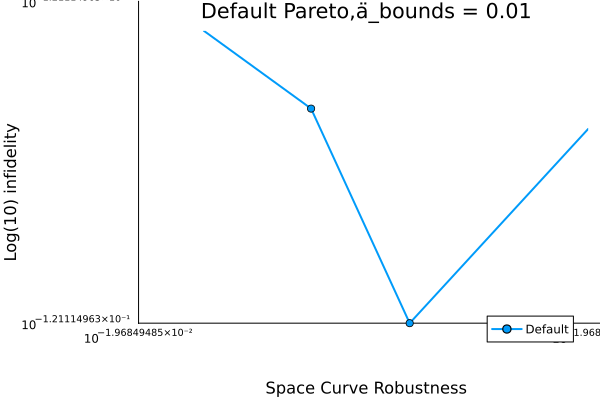

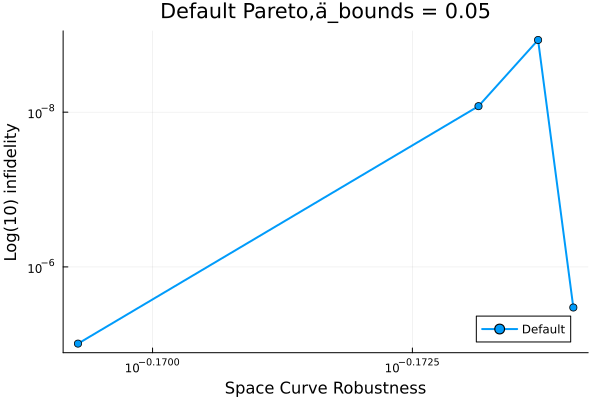

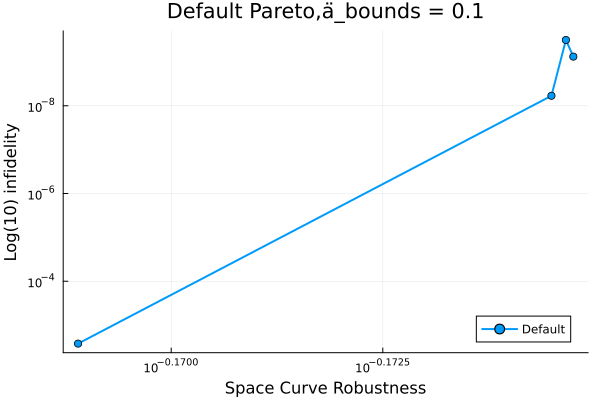

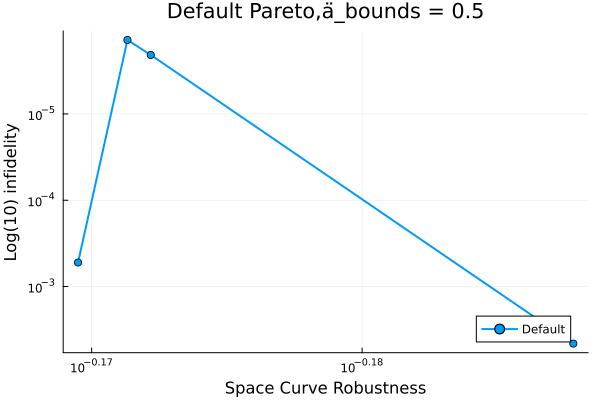

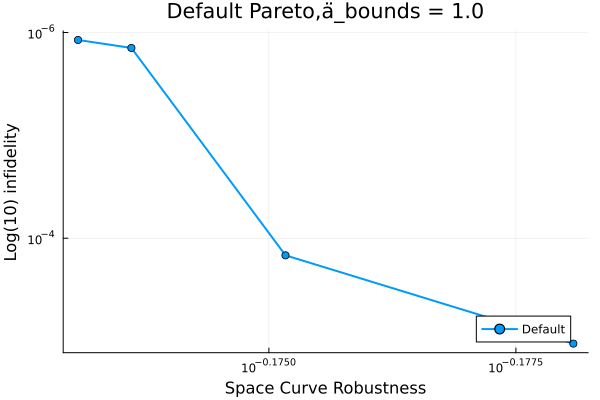

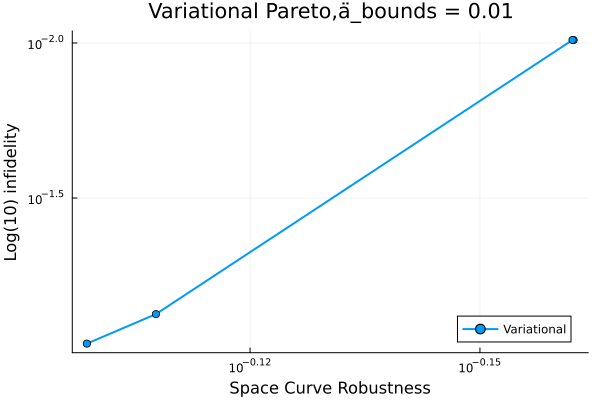

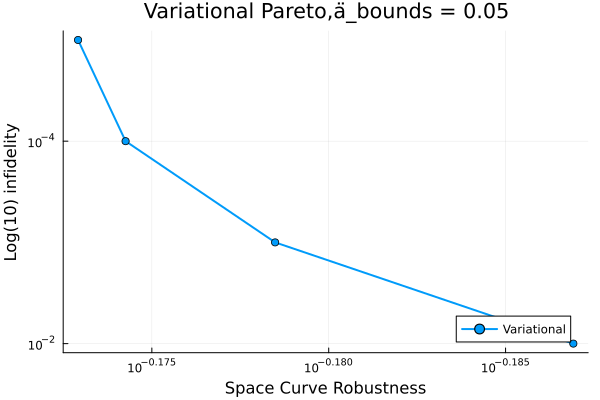

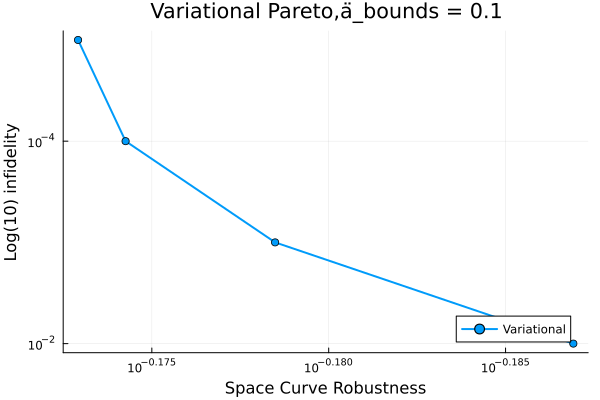

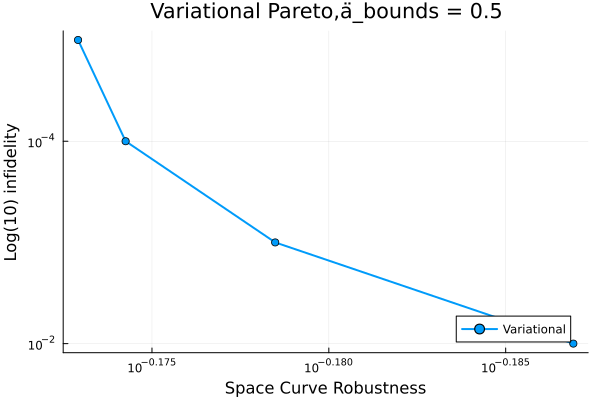

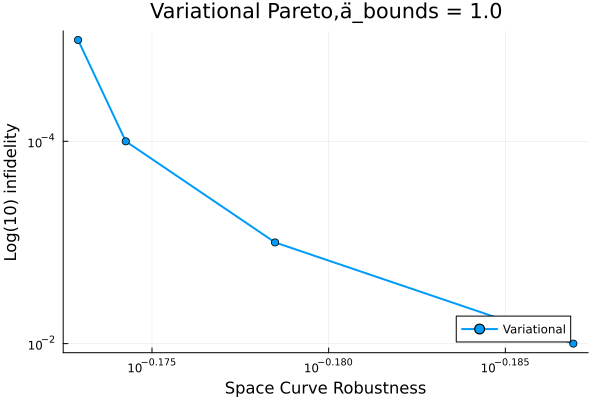

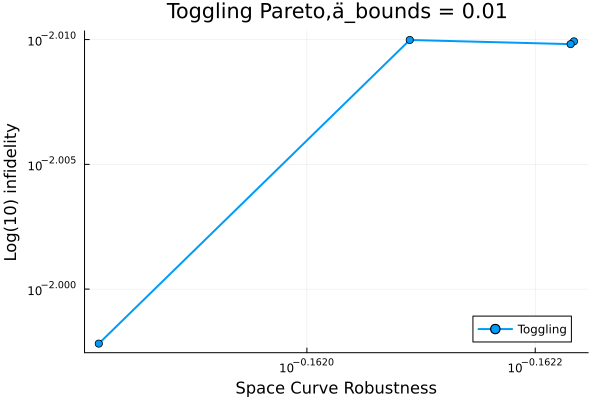

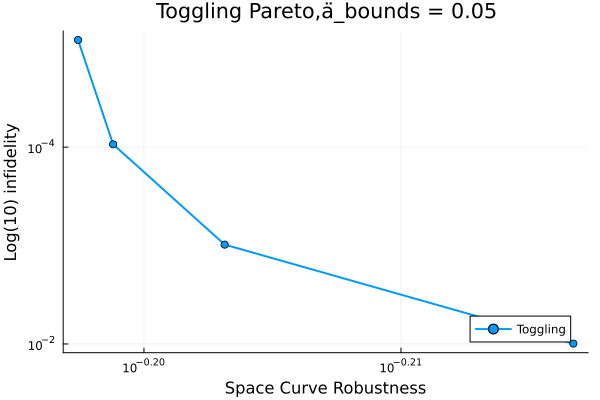

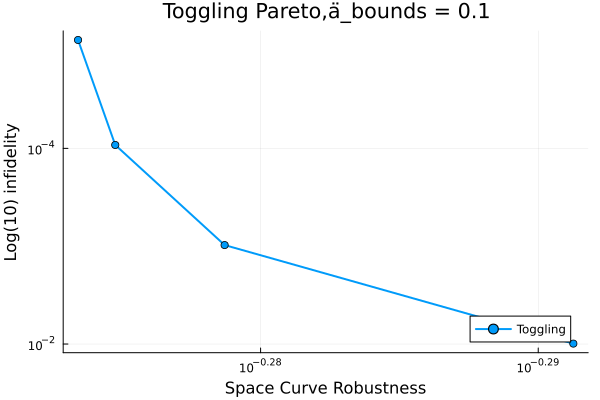

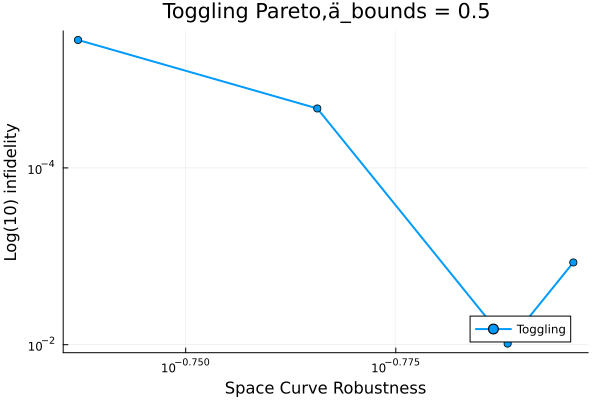

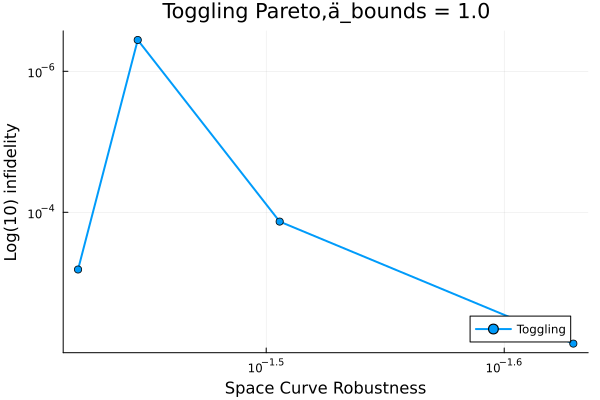

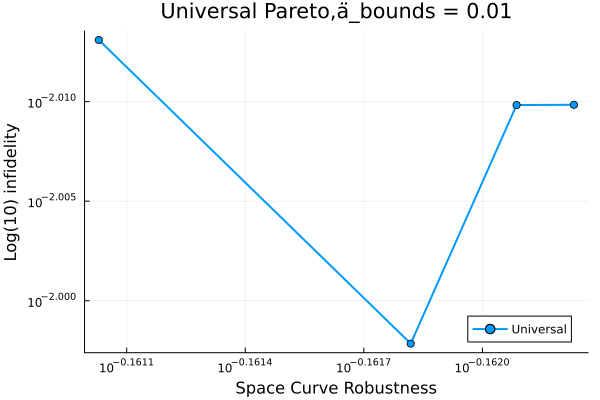

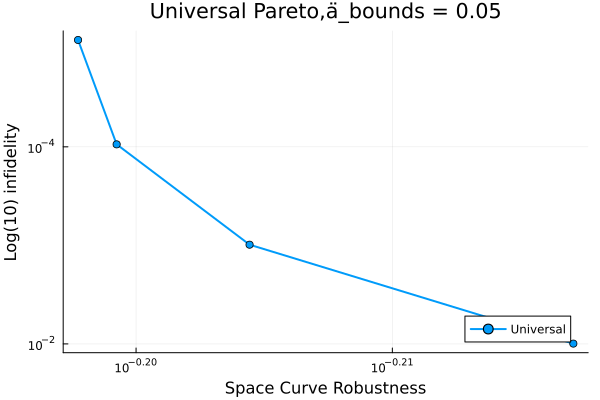

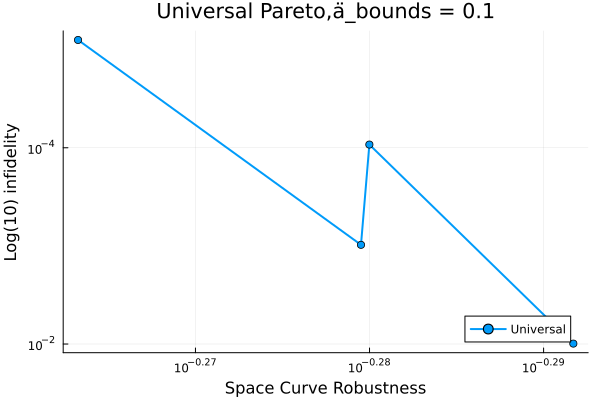

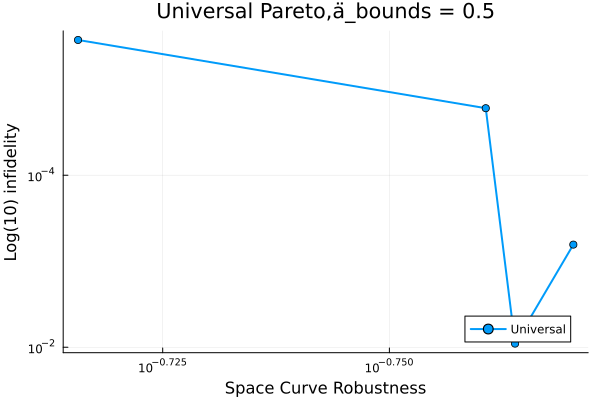

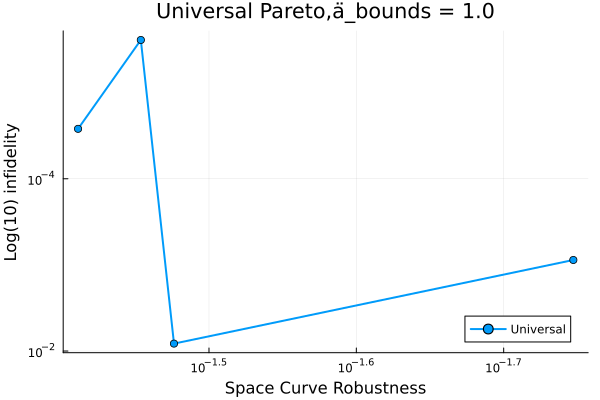

In [13]:
arr_probs = [default_probs, var_probs, tog_probs, uni_probs]
method_names = ["Default", "Variational", "Toggling", "Universal"]


for (prob_idx, probs) in enumerate(arr_probs)
    method_name = method_names[prob_idx]

    
    for s in 1:n_seeds
        dda = ddas[s]
        plt = Plots.plot(
            xlabel="Space Curve Robustness",
            ylabel="Log(10) infidelity",
            title="$method_name Pareto,ä_bounds = $dda",
            xscale = :log10, yscale = :log10,
            legend=:bottomright, grid=true,
            xflip=true,
            yflip=true
        )
        
        xs = Float64[]  # robustness from space curve
        ys = Float64[]  # infidelity
        
        for (j, f) in enumerate(final_fid_floor)
            prob = probs[s, j]
            
            # Compute robustness using space curve
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            infidelity = 1 - unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(xs, avg_robustness)
            push!(ys, infidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(xs)
        Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=method_name, linewidth=2)
        display(plt)
    end
end


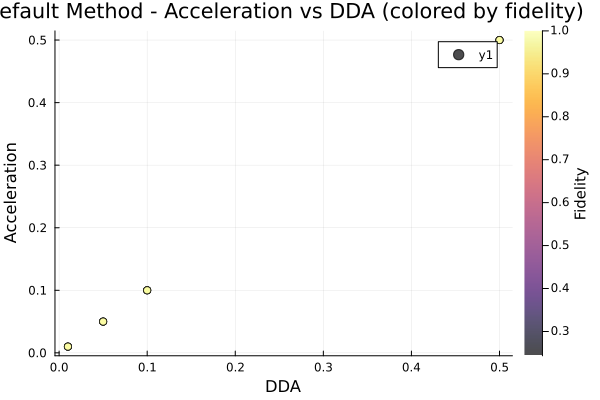

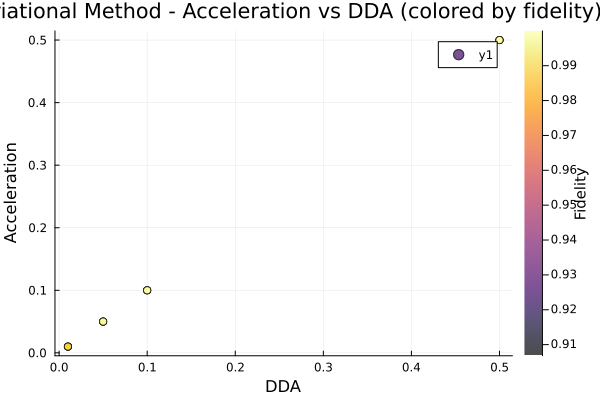

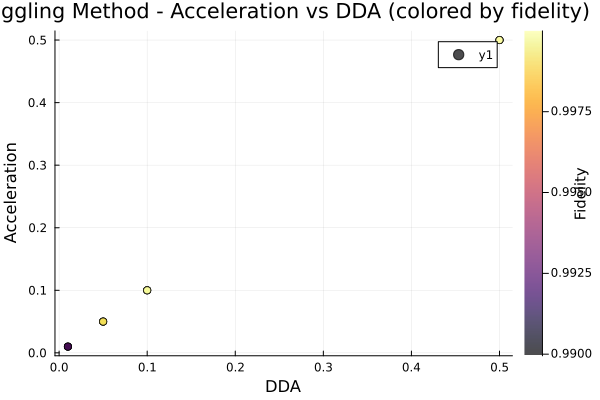

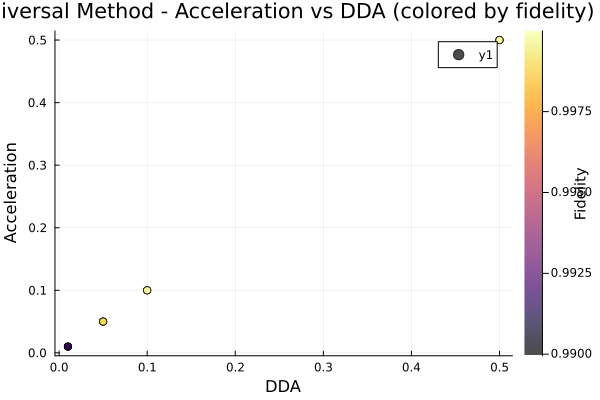

In [17]:
arr_probs = [default_probs, var_probs, tog_probs, uni_probs]
method_names = ["Default", "Variational", "Toggling", "Universal"]

for (prob_idx, probs) in enumerate(arr_probs)
    method_name = method_names[prob_idx]
    
    # Create one plot per method
    plt = Plots.plot(
        xlabel="DDA",
        ylabel="Acceleration",
        title="$method_name Method - Acceleration vs DDA (colored by fidelity)",
        legend=:topright, 
        grid=true
    )
    
    # Collect all data points for this method across seeds
    all_ddas = Float64[]
    all_accelerations = Float64[]
    all_fidelities = Float64[]
    
    for s in 1:n_seeds
        for (j, f) in enumerate(final_fid_floor)
            prob = probs[s, j]
            
            # DDA is the index j (corresponding to ddas array)
            dda_value = ddas[j]  # This gives us the actual DDA value
            acceleration = ddas[j]  # Acceleration is the same as DDA value
            
            # Calculate fidelity
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(all_ddas, dda_value)
            push!(all_accelerations, acceleration)
            push!(all_fidelities, fidelity)
        end
    end
    
    # Create scatter plot with points colored by fidelity
    Plots.scatter!(plt, all_ddas, all_accelerations, 
             zcolor=all_fidelities,
             colorbar_title="Fidelity",
             marker=:circle,
             markersize=4,
             alpha=0.7)
    
    display(plt)
end

Penalty

In [ ]:
sweep_rob_loss_λ = exp.(range(log(.1), log(1), length=10))
n_lambdas = length(sweep_rob_loss_λ)

pen_var_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_tog_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_uni_probs = Matrix{Any}(undef, n_seeds, n_lambdas)

Hₑ_add = a -> PAULIS.X + PAULIS.Y + PAULIS.Z
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive


for i in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ) 

        # var problem
        var_prob = UnitarySmoothPulseProblem(
            var_sys, U_goal, T, Δt;
            init_trajectory=deepcopy(init_var_probs[i,j].trajectory),
            piccolo_options=piccolo_opts,
            var_seed=false,
            Q_r=λ
        )
        solve!(var_prob; max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(var_prob; max_iter=50, print_level=5)
        pen_var_probs[i, λ_idx] = var_prob

        # tog problem
        tog_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_mult,
            Q_t=λ
        )
        solve!(tog_prob; max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(tog_prob; max_iter=50, print_level=5)
        pen_tog_probs[i, λ_idx] = tog_prob

        # uni problem
        uni_prob = UnitaryUniversalProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_hyperspeed=true,
            Q_t=λ
        )
        solve!(uni_prob; max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(uni_prob; max_iter=50, print_level=5)
        pen_uni_probs[i, λ_idx] = uni_prob
    end
end


### Full Plots

In [ ]:
function compute_space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    """Compute the average norm of the space curve over Pauli X, Y, Z"""
    space_curve = SpaceCurve(traj, U_goal, H_err)
    
    # Extract X, Y, Z components for each time step
    x_components = [sc[1] for sc in space_curve]
    y_components = [sc[2] for sc in space_curve]
    z_components = [sc[3] for sc in space_curve]
    
    # Compute norms for each Pauli direction
    x_norm = norm(x_components)
    y_norm = norm(y_components)
    z_norm = norm(z_components)
    
    # Return average norm
    return (x_norm + y_norm + z_norm) / 3.0
end

#### pareto with penalty

In [ ]:
# Define colors for methods
method_colors = [:blue, :red, :green]
method_names_plot = ["Variational", "Toggling", "Universal"]

H_err_add = PAULIS.X + PAULIS.Y + PAULIS.Z

for (method_idx, method_name) in enumerate(method_names_plot)
    println("Processing $method_name method...")
    
    fig = Figure(resolution=(800, 600))
    ax = Axis(fig[1, 1], 
             xlabel="Average Space Curve Robustness", 
             ylabel="Fidelity",
             title="$method_name Method: Pareto Frontier and Penalty Points")
    
    # Get the appropriate problem arrays
    if method_idx == 1  # Variational
        pareto_probs = var_probs
        penalty_probs = pen_var_probs
    elseif method_idx == 2  # Toggling
        pareto_probs = tog_probs
        penalty_probs = pen_tog_probs
    else  # Universal
        pareto_probs = uni_probs
        penalty_probs = pen_uni_probs
    end
    
    # Plot for each seed
    for s in 1:n_seeds
        # Pareto frontier points
        pareto_x = Float64[]
        pareto_y = Float64[]
        
        for j in 1:n_nines
            prob = pareto_probs[s, j]
            robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(pareto_x, robustness)
            push!(pareto_y, fidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(pareto_x)
        lines!(ax, pareto_x[ord], pareto_y[ord], 
               color=method_colors[method_idx], linewidth=2, 
               label=s == 1 ? "Pareto Frontier" : "")
        scatter!(ax, pareto_x[ord], pareto_y[ord], 
                color=method_colors[method_idx], markersize=8)
        
        # Penalty points
        penalty_x = Float64[]
        penalty_y = Float64[]
        lambda_vals = Float64[]
        
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = penalty_probs[s, λ_idx]
            robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(penalty_x, robustness)
            push!(penalty_y, fidelity)
            push!(lambda_vals, λ)
        end
        
        # Color penalty points by lambda value
        scatter!(ax, penalty_x, penalty_y, 
                color=lambda_vals, colormap=:viridis, markersize=6,
                label=s == 1 ? "Penalty Points" : "")
    end
    
    # Add colorbar for lambda values
    Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
             colormap=:viridis, label="λ value")
    
    axislegend(ax, position=:lb)
    display(fig)
end



#### comparing pareto frontiers of objectives

In [ ]:
fig = Figure(resolution=(800, 600))
ax = Axis(fig[1, 1], 
         xlabel="Average Space Curve Robustness", 
         ylabel="Fidelity",
         title="Pareto Frontiers Comparison: All Methods")

pareto_arrays = [var_probs, tog_probs, uni_probs]

for (method_idx, method_name) in enumerate(method_names_plot)
    pareto_probs = pareto_arrays[method_idx]
    
    # Collect all points for this method across all seeds
    all_x = Float64[]
    all_y = Float64[]
    
    for s in 1:n_seeds
        for j in 1:n_nines
            prob = pareto_probs[s, j]
            robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(all_x, robustness)
            push!(all_y, fidelity)
        end
    end
    
    # Sort by x-axis for smooth line
    ord = sortperm(all_x)
    lines!(ax, all_x[ord], all_y[ord], 
           color=method_colors[method_idx], linewidth=3, 
           label=method_name)
    scatter!(ax, all_x[ord], all_y[ord], 
            color=method_colors[method_idx], markersize=8)
end

axislegend(ax, position=:lb)
display(fig)



### comparing penalty method performace of objective

In [ ]:
fig = Figure(resolution=(800, 600))
ax = Axis(fig[1, 1], 
         xlabel="Average Space Curve Robustness", 
         ylabel="Fidelity",
         title="Penalty Points Comparison: All Methods")

penalty_arrays = [pen_var_probs, pen_tog_probs, pen_uni_probs]

for (method_idx, method_name) in enumerate(method_names_plot)
    penalty_probs = penalty_arrays[method_idx]
    
    # Collect all points for this method across all seeds and lambdas
    all_x = Float64[]
    all_y = Float64[]
    all_lambda = Float64[]
    
    for s in 1:n_seeds
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = penalty_probs[s, λ_idx]
            robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(all_x, robustness)
            push!(all_y, fidelity)
            push!(all_lambda, λ)
        end
    end
    
    # Use different color schemes for each method to distinguish them
    colormap = [:Blues, :Reds, :Greens][method_idx]
    scatter!(ax, all_x, all_y, 
            color=all_lambda, colormap=colormap, markersize=8,
            label=method_name)
end

# Create custom colorbar showing lambda range
Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
         colormap=:viridis, label="λ value")

axislegend(ax, position=:lb)
display(fig)

println("All plots completed!")

# Optional: Save plots
# save("pareto_comparison.png", fig)



In [ ]:
# Summary statistics
println("\nSummary Statistics:")
println("==================")

for (method_idx, method_name) in enumerate(method_names_plot)
    println("\n$method_name Method:")
    
    if method_idx == 1
        probs = var_probs
    elseif method_idx == 2
        probs = tog_probs
    else
        probs = uni_probs
    end
    
    robustness_vals = Float64[]
    fidelity_vals = Float64[]
    
    for s in 1:n_seeds, j in 1:n_nines
        prob = probs[s, j]
        robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
        fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
        
        push!(robustness_vals, robustness)
        push!(fidelity_vals, fidelity)
    end
    
    println("  Robustness range: $(round(minimum(robustness_vals), digits=6)) - $(round(maximum(robustness_vals), digits=6))")
    println("  Fidelity range: $(round(minimum(fidelity_vals), digits=6)) - $(round(maximum(fidelity_vals), digits=6))")
    println("  Mean robustness: $(round(mean(robustness_vals), digits=6))")
    println("  Mean fidelity: $(round(mean(fidelity_vals), digits=6))")
end

### sanity checks 

Final Fidelity Table

In [12]:
# H_drive_add = H_drive
# εs = 0:0.005:0.2
# # colors = Makie.wong_colors()

# # Get fid for each problem
# for seed_idx in 1:n_seeds
#     display("\nseed idx = $seed_idx:")
#     display("Final f | Base Fidelity | Add Fidelity | Mult Fidelity ")
#     display("-" ^ 40)
#     for (j, f) in enumerate(final_fid_floor)
#             def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
#             add_fid = unitary_rollout_fidelity(final_add_probs[seed_idx, j].trajectory, sys)
#             mult_fid = unitary_rollout_fidelity(final_mult_probs[seed_idx, j].trajectory, sys)
#             display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) |")
#     end
# end

Plot Fidelity vs Error

In [13]:
# εs     = 0:0.01:0.5
# floors = final_fid_floor

# # Build a continuous colormap and a normalizer for the floor values
# cmap   = cgrad(:viridis)  # perceptually uniform
# fmin, fmax = extrema(floors)
# nfloor(x) = fmax == fmin ? 0.5 : (x - fmin) / (fmax - fmin)  # safeguard for flat ranges

# # Helper: get the color for a given floor
# floor_color(f) = cmap[nfloor(f)]

# # Helper to plot one seed, additive-only
# function plot_seed_additive(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — additive error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         # Base (default) trajectory at this floor
#         def_traj  = default_probs[seed_idx, j].trajectory
#         # Optimized (toggle) trajectory at this floor
#         add_traj  = final_add_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_add = [unitary_rollout_fidelity(
#                       add_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]

#         # same hue for the pair; dashed = base, solid = optimized
#         lines!(ax, εs, ys_def, color=c, linestyle=:dash,
#                label="base @ $(round(f; digits=6))")
#         lines!(ax, εs, ys_add, color=c, linestyle=:solid,
#                label="add toggle @ $(round(f; digits=6))")
#     end

#     # Legend + continuous colorbar keyed to floor
#     axislegend(ax, position=:lb, nbanks=2)
#     Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")

#     fig
# end

# # Helper to plot one seed, multiplicative-only
# function plot_seed_multiplicative(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — multiplicative error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         # Base (default) trajectory at this floor
#         def_traj  = default_probs[seed_idx, j].trajectory
#         # Optimized (toggle) trajectory at this floor
#         mult_traj = final_mult_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_mult = [unitary_rollout_fidelity(
#                        mult_traj,
#                        QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                    ) for ε in εs]

#         lines!(ax, εs, ys_def,  color=c, linestyle=:dash,
#                label="base @ $(round(f; digits=6))")
#         lines!(ax, εs, ys_mult, color=c, linestyle=:solid,
#                label="mult toggle @ $(round(f; digits=6))")
#     end

#     axislegend(ax, position=:lb, nbanks=2)
#     Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")

#     fig
# end


In [14]:
# εs     = 0:0.01:0.5
# using Makie: LineElement


# const LINE_ALPHA = 0.8
# const LINEWIDTH  = 1.2
# const YMAX       = 1.0

# function finalize_axes!(fig, ax; cmap, fmin, fmax, ymin_seen)
#     ylo = 0.9#min(0.9, ymin_seen)                   # expand lower only if needed
#     Makie.ylims!(ax, ylo, 1.0)                  # qualify to avoid Plots clash

#     ax.yticks = 0.90:0.02:1.00
#     ax.ytickformat = vals -> string.(round.(vals; digits=2))

#     # Optional grid styling (works if your Makie version exposes these fields):
#     # ax.xgridvisible = true;  ax.ygridvisible = true
#     # ax.xgridcolor   = (:gray, 0.25); ax.ygridcolor = (:gray, 0.25)
#     # ax.xgridwidth   = 0.8;           ax.ygridwidth = 0.8

#     style_elems = [
#         LineElement(color=:black, linestyle=:dash,  linewidth=1.2),
#         LineElement(color=:black, linestyle=:solid, linewidth=1.2),
#     ]
#     Makie.axislegend(ax, style_elems, ["base", "optimized"], position=:lb)
#     Makie.Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")
# end

# function plot_seed_additive(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — additive error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     ymin_seen = Inf

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         def_traj = default_probs[seed_idx, j].trajectory
#         add_traj = final_add_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_add = [unitary_rollout_fidelity(
#                       add_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]

#         # Track global minimum so we never hide data
#         ymin_seen = min(ymin_seen, minimum(ys_def), minimum(ys_add))

#         # Same hue for the pair; dashed = base, solid = optimized
#         lines!(ax, εs, ys_def, color=(c, LINE_ALPHA), linestyle=:dash,  linewidth=LINEWIDTH)
#         lines!(ax, εs, ys_add, color=(c, LINE_ALPHA), linestyle=:solid, linewidth=LINEWIDTH)
#     end

#     finalize_axes!(fig, ax; cmap=cmap, fmin=fmin, fmax=fmax, ymin_seen=ymin_seen)
#     fig
# end

# function plot_seed_multiplicative(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — multiplicative error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     ymin_seen = Inf

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         def_traj  = default_probs[seed_idx, j].trajectory
#         mult_traj = final_mult_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_mult = [unitary_rollout_fidelity(
#                        mult_traj,
#                        QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                    ) for ε in εs]

#         ymin_seen = min(ymin_seen, minimum(ys_def), minimum(ys_mult))

#         lines!(ax, εs, ys_def,  color=(c, LINE_ALPHA), linestyle=:dash,  linewidth=LINEWIDTH)
#         lines!(ax, εs, ys_mult, color=(c, LINE_ALPHA), linestyle=:solid, linewidth=LINEWIDTH)
#     end

#     finalize_axes!(fig, ax; cmap=cmap, fmin=fmin, fmax=fmax, ymin_seen=ymin_seen)
#     fig
# end


In [15]:
# using JLD2
# using Dates

# # Collect trajectories only (lighter than storing whole problem objects)
# default_trajs    = [default_probs[i, j].trajectory    for i in 1:n_seeds, j in 1:n_nines]
# warm_add_trajs   = [init_var_probs[i, j].trajectory   for i in 1:n_seeds, j in 1:n_nines]
# warm_mult_trajs  = [warm_mult_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
# final_add_trajs  = [final_add_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
# final_mult_trajs = [final_mult_probs[i, j].trajectory for i in 1:n_seeds, j in 1:n_nines]

# # Optional: fidelity traces you computed
# fid_traces = Dict(
#     "init_def_fids"  => init_def_fids,
#     "init_add_fids"  => init_add_fids,
#     "init_mult_fids" => init_mult_fids,
# )

# # Minimal metadata to reconstruct the setup
# meta = Dict(
#     "T" => T,
#     "Δt" => Δt,
#     "U_goal" => U_goal,
#     "n_seeds" => n_seeds,
#     "n_nines" => n_nines,
#     "final_fid_floor" => final_fid_floor,
#     "control_bounds" => control_bounds,
#     "n_drives" => n_drives,
# )

# # Make an artifacts/ folder and generate a timestamped filename
# mkpath("artifacts")
# timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
# outfile = joinpath("artifacts", "trajectories_$(timestamp).jld2")

# @info "Saving trajectories to $outfile"
# @save outfile default_trajs warm_add_trajs warm_mult_trajs final_add_trajs final_mult_trajs fid_traces meta
# @info "Done. Saved keys: default_trajs, warm_add_trajs, warm_mult_trajs, final_add_trajs, final_mult_trajs, fid_traces, meta"


To load the data for later, use:

In [16]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs warm_add_trajs warm_mult_trajs final_add_trajs final_mult_trajs fid_traces meta
